## **CBOW Word Embeddings**

In this notebook, we will compute word embeddings and use them for sentiment analysis.
- To implement sentiment analysis, we can go beyond counting the number of positive words and negative words. 
- We can find a way to represent each word numerically, by a vector. 
- The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures. 

We will explore a classic way of generating word embeddings or representations.
- We will implement the continuous bag of words (CBOW) model. 

### **The Continuous bag of words model**

Let's take a look at the following sentence: 
>**'I am happy because I am learning'**. 

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if we were to choose a context half-size of say $C = 2$, then we would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am] 

> $C$ words after: [because, I] 

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of our model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://angqpdfr.coursera-apps.org/notebooks/Week4/word2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /></div>

Where $\bar x$ is the average of all the one hot vectors of the context words. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://angqpdfr.coursera-apps.org/notebooks/Week4/mean_vec2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /></div>

Once we have encoded all the context words, we can use $\bar x$ as the input to our model. 

The architecture we will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1   \\
 a &= ReLU(h)   \\
 z &= W_2 \  a + b_2    \\
 \hat y &= softmax(z)    \\
\end{align}

In [ ]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca, get_dict

In [ ]:
# download sentence tokenizer
nltk.data.path.append('.')

In [ ]:
# load, tokenize and process the data
import re                                                           #  Load the Regex-module
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punctuations are replaced by '.'
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [ ]:
# computing the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq

Size of vocabulary:  5778
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### **Mapping words to indices and indices to words**
We will use a helper function `get_dict()`, available in **utils2.py**, to create a dictionary that maps words to indices and indices to words.

In [ ]:
# get_dict creates two dictionaries, converting words to indices and vice-versa
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5778


In [ ]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2745
Word which has index 2743:   kindness


### **Training the Model**

####  **Initializing the model**

We will now initialize two matrices and two vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in our vocabulary and $N$ is the dimension of our word vector
- The second matrix ($W_2$) is of dimension $V \times N$
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$ 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$

In [ ]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''    
    np.random.seed(random_seed)
    
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    return W1, W2, b1, b2

In [ ]:
# testing the function
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


### Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }   $$

- Array indexing in code starts at 0
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$)
- $i$ goes from 0 to |V| - 1

In [ ]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
        
    return yhat

In [ ]:
# testing the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

#### **Forward propagation**


In [ ]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    h = np.dot(W1,x) + b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0, h)
    
    # calculate z
    z = np.dot(W2,h) + b2

    return z, h

In [ ]:
# testing the function

# create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


#### **Cost function**

- We will implement the *cross-entropy* cost function.

In [ ]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [ ]:
# testing the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 9.9560


#### **Training the Model - Backpropagation**




In [ ]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    # compute l1 as W2^T (Yhat - Y) and
    # re-use it whenever we see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T, (yhat-y))
    # apply relu to l1
    l1 = np.maximum(0, l1)
    # compute the gradient of W1 (#1/m * relu(w2.T(yhat-y)) . xT)
    grad_W1 = (1/batch_size) * np.dot(l1,x.T)
    # compute the gradient of W2
    grad_W2 = (1/batch_size) * np.dot(yhat-y,h.T)
    # compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [ ]:
# testing the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)


#### **Gradient Descent**


In [ ]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # get yhat
        yhat = softmax(z)
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # gpdate weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [ ]:
# testing the function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.107177
iters: 20 cost: 0.038644
iters: 30 cost: 0.023685
iters: 40 cost: 0.017095
iters: 50 cost: 0.013380
iters: 60 cost: 0.010995
iters: 70 cost: 0.009333
iters: 80 cost: 0.008108
iters: 90 cost: 0.007168
iters: 100 cost: 0.006423
iters: 110 cost: 0.005992
iters: 120 cost: 0.005633
iters: 130 cost: 0.005314
iters: 140 cost: 0.005030
iters: 150 cost: 0.004774


#### **Visualizing the word vectors**

We will try and visualize the word vectors trained using the functions we created.

In [ ]:
# visualizing the word vectors
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, return a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2745, 3951, 2961, 3023, 5675, 1452, 5674, 4191, 2316, 4278]


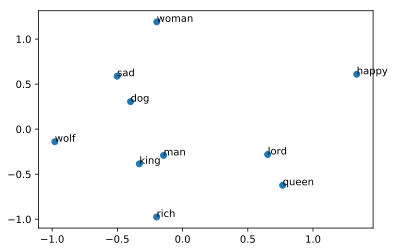

In [ ]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

We can see that man and king are next to each other. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

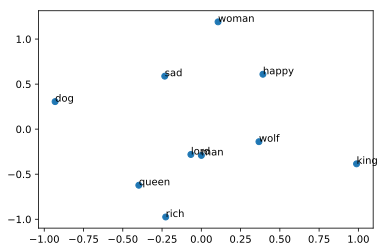

In [ ]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()